In [1]:
from __future__ import print_function

import argparse
import sys
import torch
import os
import glob

from utils import get_config
from trainer import MUNIT_Trainer, UNIT_Trainer

from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision import transforms

from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
class Opts:
    def __init__(self):
        self.config = "/home/soonyau/temp/config_3.yaml"
        self.input = "./mvp_inputs/input.jpg" 
        self.output_folder = "./mvp_results" 
        self.checkpoint = "/home/soonyau/temp/checkpoints/edges2fashion_4.pt"
        self.style = ""
        self.a2b = 1
        self.seed = 10
        self.num_style = 1
        self.synchronized = True
        self.output_only = True
        self.output_path = ""
        self.trainer = "MUNIT"
        
opts = Opts()

In [4]:
torch.manual_seed(opts.seed)
torch.cuda.manual_seed(opts.seed)
if not os.path.exists(opts.output_folder):
    os.makedirs(opts.output_folder)
config = get_config(opts.config)
opts.num_style = 1 if opts.style != '' else opts.num_style

config['vgg_model_path'] = opts.output_path
style_dim = config['gen']['style_dim']
trainer = MUNIT_Trainer(config)

state_dict = torch.load(opts.checkpoint)
trainer.gen_a.load_state_dict(state_dict['a'])
trainer.gen_b.load_state_dict(state_dict['b'])
trainer.cuda()
trainer.eval()
encode = trainer.gen_a.encode if opts.a2b else trainer.gen_b.encode # encode function
style_encode = trainer.gen_b.encode if opts.a2b else trainer.gen_a.encode # encode function
decode = trainer.gen_b.decode if opts.a2b else trainer.gen_a.decode # decode function


if 'new_size' in config:
    new_size = config['new_size']
else:
    if opts.a2b==1:
        new_size = config['new_size_a']
    else:
        new_size = config['new_size_b']


In [21]:
#input_dir = '/home/soonyau/dataset/fashion/zalando_munit/testA/'
input_dir = 'inputs/'
sketch_files = [fname for fname in glob.glob(input_dir+'*')]
sketch_files.sort()
print(sketch_files)
plt.rcParams['figure.figsize'] = [7, 3.5]

['inputs/plain.png', 'inputs/plain_2.png', 'inputs/plain_pocket.png', 'inputs/plain_stripe.png', 'inputs/plain_v.png']


In [22]:
style_rand = Variable(torch.randn(opts.num_style, style_dim, 1, 1).cuda())

def generate(raw_img, style_rand):
    with torch.no_grad():
        plt.subplot(121)
        plt.imshow(raw_img)
        transform = transforms.Compose([transforms.Resize(new_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        image = Variable(transform(raw_img).unsqueeze(0).cuda())
        style_image = Variable(transform(Image.open(opts.style).convert('RGB')).unsqueeze(0).cuda()) if opts.style != '' else None

        content, _ = encode(image)
    
        if opts.style != '':
            _, style = style_encode(style_image)
        else:
            style = style_rand
        for j in range(opts.num_style):
            s = style[j].unsqueeze(0)
            outputs = decode(content, s)
            
            outputs = (outputs + 1) / 2.
            path = os.path.join(opts.output_folder, 'output{:03d}.jpg'.format(j))
            vutils.save_image(outputs.data, path, padding=0, normalize=True)                
            gen_img = Image.open(path).convert('RGB')
            #transform_to_img = transforms.Compose([transforms.ToPILImage()])
            #transformed_img = Variable(transform_to_img(outputs[0].cuda())).cuda()
            #transformed_img = transforms.ToPILImage()
            plt.subplot(122)            
            plt.imshow(gen_img)
            plt.show()
            

inputs/plain_stripe.png
(512, 512)


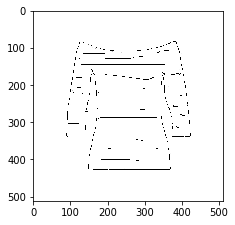

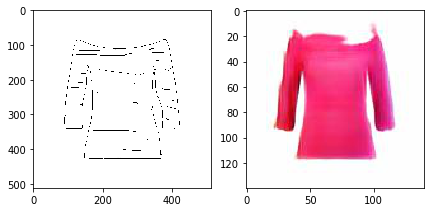

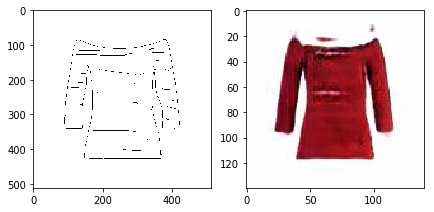

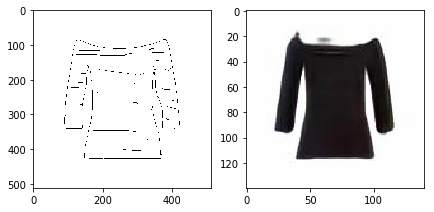

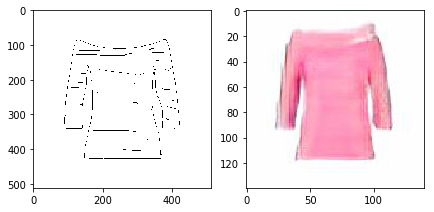

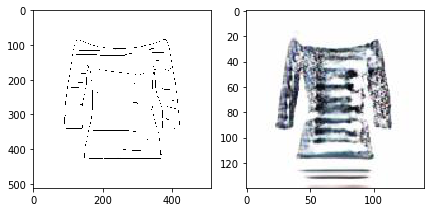

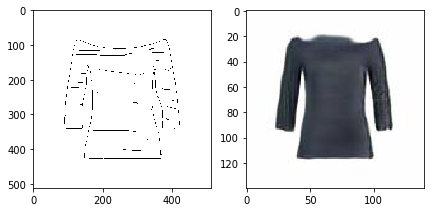

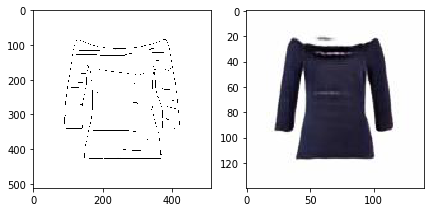

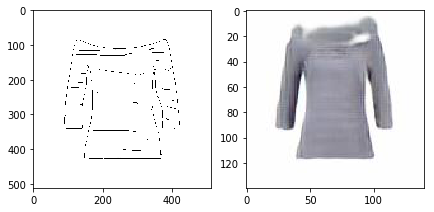

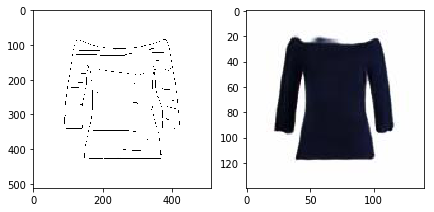

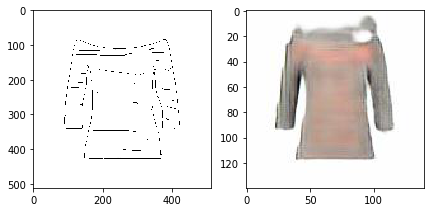

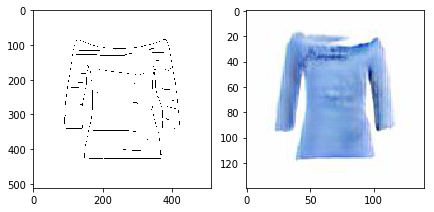

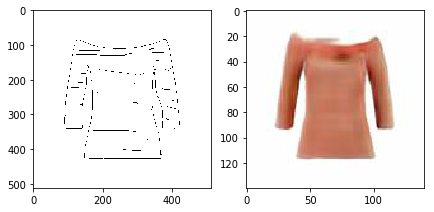

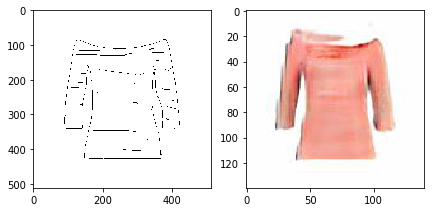

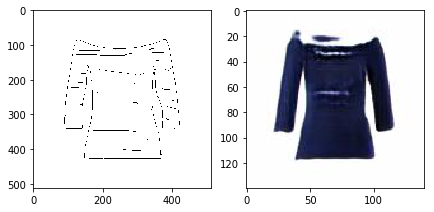

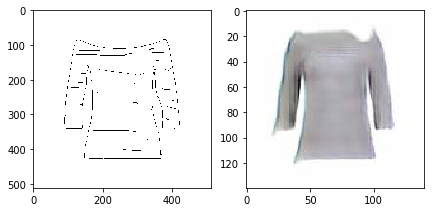

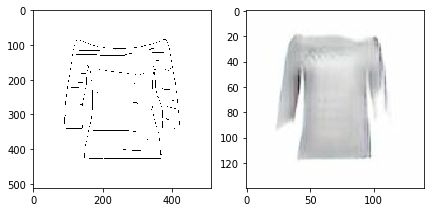

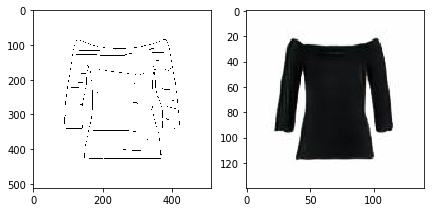

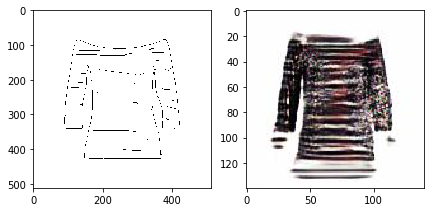

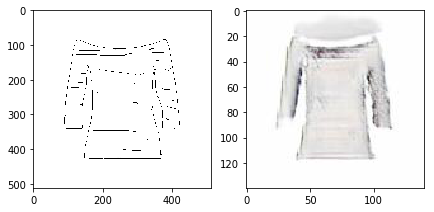

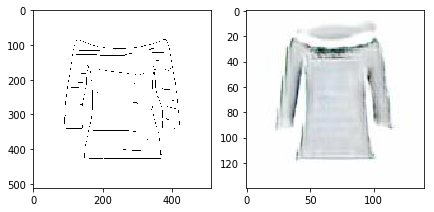

In [23]:
idx = 3
for i in range(idx,idx+1):
    print(sketch_files[i])
    raw_img = Image.open(sketch_files[i]).convert('RGB')
    print(raw_img.size)
    plt.imshow(raw_img)
    plt.show()
    rand_idx = 40
    sweeps = [x * 0.2 -1 for x in range(0, 20)]
    for s in sweeps:
        style_rand_ = Variable(torch.randn(opts.num_style, style_dim, 1, 1).cuda())
        #style_rand_ = style_rand
        #style_rand_[0][rand_idx][0] = s
        generate(raw_img, style_rand_)


In [25]:
          
def generate_wrapper(val0, val1, val2, val3, val4, val5, val6, val7):
    style_rand[0][0][0] = val0
    style_rand[0][1][0] = val1
    style_rand[0][2][0] = val2
    style_rand[0][3][0] = val3
    style_rand[0][4][0] = val4
    style_rand[0][5][0] = val5
    style_rand[0][6][0] = val6
    style_rand[0][7][0] = val7
    
    #style_rand_ = style_rand
    #style_rand_[0][3][0] = i
    raw_img = Image.open(sketch_files[2]).convert('RGB')
    generate(raw_img, style_rand)

latent_vars=[]
for j in range(style_dim):
    latent_vars.append(widgets.FloatSlider(min=-2, max=2, value=style_rand[0][j][0], description=str(j)))

widgets.interactive(generate_wrapper,
                    val0 = latent_vars[0],
                    val1 = latent_vars[1],
                    val2 = latent_vars[2],
                    val3 = latent_vars[3],
                    val4 = latent_vars[4],
                    val5 = latent_vars[5],
                    val6 = latent_vars[6],
                    val7 = latent_vars[7])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPS0wLjUsIGRlc2NyaXB0aW9uPXUnMCcsIG1heD0yLjAsIG1pbj0tMi4wKSwgRmxvYXRTbGlkZXIodmFsdWU9LTAuMzAwMDDigKY=
